In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa.seasonal as seasonal
from statsmodels.tsa.statespace.sarimax import SARIMAX


import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv2D, Dropout
from keras.callbacks import LearningRateScheduler


import xgboost as xgb
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


# clean data

In [2]:
def clean(data,date_column='Date'):
    """
    in this function we add steps related to data cleansing (unwanted columns removal, NA values, ...)
    data (dataframe): input data that should be cleaned
    date_column (string): name of the date column 
    
    returns cleaned data
    """
    # remove undefined column
    data.drop(['Unnamed: 0'],axis=1,inplace=True)

    #check for null values and fill them with 0
    #data[data.isna()].count()
    #data.fillna(0)

    #Convert Date column to DateTime format
    try:
        data[date_column]=pd.to_datetime(data[date_column])
    except:
        raise ValueError('input data should have a date column specified by date_column argument')
    return data

## Create dataset

- To create data from time-series we consider a sequence of n observations and set the mean value of stock market for the next week (mean of the next 7 days) as target. 
- if you think normalization is needed for your data, you can do it before generating data for case of simplicity. We are going to try our model without normalization of data (the values are almost in the same range and quite close to each other)

In [3]:
def generate_target(data,window_size=7):
    """
     calculates target as the average of next "window-size" days in market.
     
     input
     data: the column form data we want to predict
     window_size (int): rolling window size 
     
     returns (numpy array): the rolling average of stock market price
    """
    return data.rolling(window=window_size).mean().dropna().values

def generate_dataset(data,num_features):
    """
     returns data and target sets 
     
     data: the column form data we want to predict
     num_features (int): the number of features in each data sample
    """
    features=[]
    target = generate_target(data,window_size=num_features)
    #maximum data points in the final dataset
    max_indx=len(data)-num_features+1
    
    for i in range(0,max_indx):      
        temp=data[np.arange(i,i+num_features)].values
#         temp=np.append(temp,target[0])
        features.append(temp)
#         target=np.delete(target,0)
    return features,target

def train_test_split(dataset,target=[],test_size=0.2):
    """
    split train and test sets
    
    input
    dataset (numpy array): data containing all data point
    target (numpy.array): the target value for each data point (if not specified the last column of dataset would be considered as target)
    test_size (float): the percentage of dataset reserved for test
    
    return train data and label, test data and label
    """
    length= int(len(dataset)*(1-test_size))
    
    #if target is provided --> use it as target for data
    if target.any():
        assert len(dataset)==len(target),'Dataset and target must have the same number of rows.'
        train_data,train_target =dataset[:length],target[:length]
        test_data,test_target=dataset[length:],target[length:]
    # else use the last column of the data as target
    else:
        train_data,train_target =dataset[:length,:-1],dataset[:length,-1]
        test_data,test_target=dataset[length:,:-1],target[length,-1]
    return train_data,train_target,test_data,test_target

def add_column(data,column):
    """
    add column to data
    input
    data (dataframe or numpy list): the data to which new column should be added
    column (numpy array): the column to add to data
    """
    if isinstance(data, pd.DataFrame):
        try:
            data['new'] = column
        except:
            raise ValueError('Failed to add the new column.')
        return data
    return [np.append(data[i],column[i]) for i in range(len(data))]

# Create model

In [15]:
class CreateModel():
    def __init__(self,num_features):
        self.num_features= num_features
        self.callbacks = [LearningRateScheduler(self.lr_scheduler, verbose=1)]
        
    def lr_scheduler(self, epoch,lr):
        """
        dynamically changes the learning rate for better learning process
        """
        #larning rate decay rate
        decay_rate = 0.90
        decay_step = 2
        if epoch % decay_step == 0 and epoch:
            return lr *decay_rate
        return lr
    
    def generate_model(self):
        model=Sequential()
        model.add(LSTM(10, return_sequences=True,input_shape=(1, self.num_features)))
        model.add(LSTM(10,return_sequences=True))
        model.add(Dropout(0.4))
        model.add(Dense(40))
        model.add(Dropout(0.4))
        model.add(LSTM(20))
        model.add(Dense(10,activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        return model
        

In [12]:
def plot_result(target,prediction,xtick_label,plot_title='train'):
    assert plot_title.lower() in ('train','test'),'Invalid value set for plot type argument (it must either be train or test.'
    df=pd.DataFrame()
    df['observation']=target
    df['predicton']=prediction
    df['Date']= xtick_label
    df.set_index('Date').plot(figsize=(14,7),fontsize=12)
    plt.title('%s set performance evaluation'%plot_title.title(),fontsize=18)
    plt.legend(fontsize=14)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Stock price',fontsize=14)
    plt.grid()

# Entry point

In [16]:
#entry point
num_features=7 # how many preceding days should be considered for data generation
test_size= 0.2 # the precentage of data reserved for test

data=pd.read_csv('AMZON.csv')
#clean data
data= clean(data)
length=int(len(data)*(1-test_size))
labels=data['Date']
train_xlabel= labels.values[:length]
test_xlabel= labels.values[length:]

#Choose the column for prediction 
df=data['Close'].apply(lambda x: round(x,3))

# create data and target and split them to train and test
dataset,target=generate_dataset(df,num_features=num_features)
train_data,train_target, test_data, test_target = train_test_split(dataset,target,test_size=test_size)

#normalize data
train=add_column(train_data,train_target)
test=add_column(test_data,test_target)
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

# prepare data for training
train_data,train_target= train[:,:-1],train[:,-1]
test_data,test_target= test[:,:-1],test[:,-1]
train_data = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))
train_target=np.reshape(train_target,(-1,1))

# create model
my_model=CreateModel(num_features=num_features)
model= my_model.generate_model()
model.fit(train_data, train_target, callbacks=my_model.callbacks, epochs=50, batch_size=5, verbose=2)
model.save('lstm_model.h5')

#predict
yhat=model.predict(train_data)
yhat_test=model.predict(test_data)

# inverse normalization
train_scaled = scaler.inverse_transform(train)
test_scaled = scaler.inverse_transform(test)
train_target=[x[-1] for x in train_scaled]
test_target=[x[-1] for x in test_scaled]

train=add_column(train[:,:-1],yhat)
test=add_column(test[:,:-1],yhat_test)
train_scaled = scaler.inverse_transform(train)
test_scaled = scaler.inverse_transform(test)
train_predict=[x[-1] for x in train_scaled]
test_predict=[x[-1] for x in test_scaled]

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
 - 2s - loss: 0.0278
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
 - 1s - loss: 0.0069
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009000000427477062.
 - 1s - loss: 0.0047
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009000000427477062.
 - 1s - loss: 0.0037
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0008100000384729356.
 - 1s - loss: 0.0037
Epoch 6/50

Epoch 00006: LearningRateScheduler setting learning rate to 0.0008100000559352338.
 - 1s - loss: 0.0034
Epoch 7/50

Epoch 00007: LearningRateScheduler setting learning rate to 0.0007290000503417104.
 - 1s - loss: 0.0035
Epoch 8/50

Epoch 00008: LearningRateScheduler setting learning rate to 0.0007290000794455409.
 - 1s - loss: 0.0036
Epoch 9/50

Epoch 00009: LearningRateScheduler setting learning rate to 

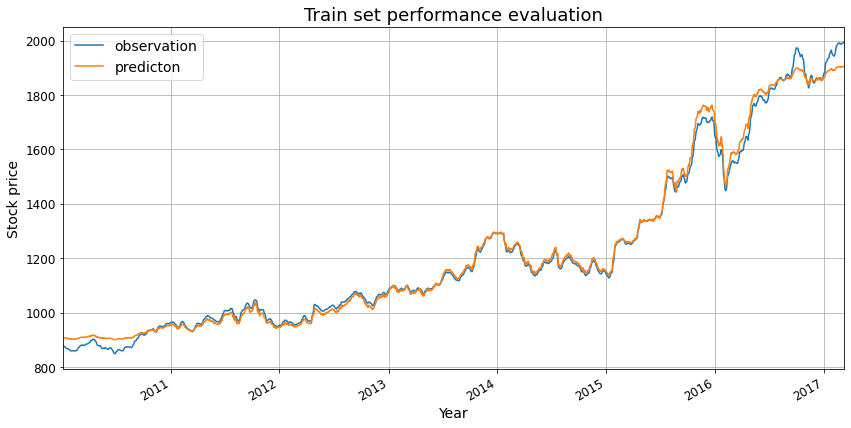

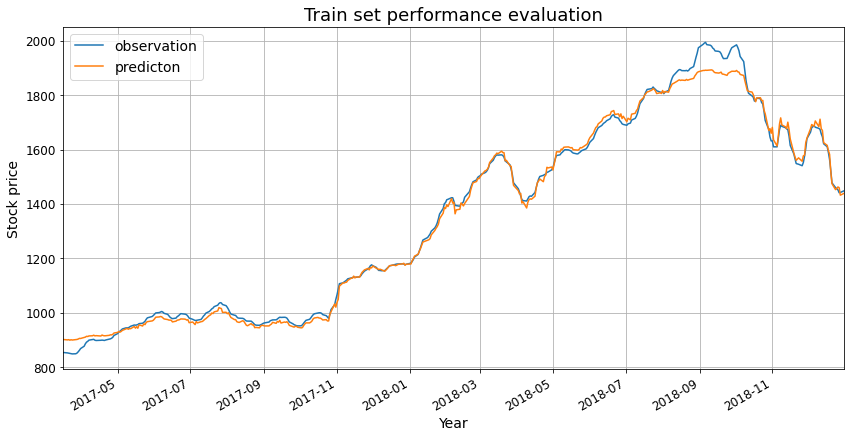

In [13]:
plot_result(train_target,train_predict,train_xlabel[:len(train_target)])
plot_result(test_target,test_predict,test_xlabel[:len(test_predict)])

# observation
The intresting observation here is that even though all through the training set we see an increasing trend and the significant dicrease in stock happens only after November 2018 (which is not included in the training set at all), the developed model can actually accurately predict this change in trend and adopt with it.

# over-fitting and under-fitting solutions

To overcome the problem of over-fitting and under-fitting we faced during developing the model, we used following steps:

- Normalizing data (for under-fitting)
- dynamic learning rate using callbacks in Keras
- Dropout layers included in the model architecture
- Adding dense layers in middle of LSTM layers
- tuning the value of epoch numbers
- tuning learning rate decay rate
- using multivariate time-series analysis instead of simple univariate approach